In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
from sklearn import mixture

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

import itertools
import scipy as sp
from scipy import linalg
import matplotlib as mpl

from itertools import product
from scipy import stats

import math
%matplotlib inline

In [2]:
df = pd.read_csv('data/Test_data_07_11_2015.csv', sep=',')

In [3]:
X = df[["V1","V2","V3","I1","I2","I3","Pges","Sges","CosPhi"]]

In [4]:
X.shape

(76130, 9)

# Inject anomalies dynamically for some range defined as below

In [5]:
def add_anomaly_dynamically(num,x,count,mid_pos):
    t_num = list(num)
    if (mid_pos + count >= len(t_num)) and (mid_pos - count < 0):
        print "Point of injection is not suitable for injecting anomalies"
    else:
        #t_num.sort() #changed to work on multidimensional data, uncomment if its a 1D data
        last_idx = len(t_num)
        delta = 1.0 + (float(x)/float(100))
        new_list_test = [t_num[mid_pos]]
        for j in range(0,count):
            a = mid_pos - j
            b = mid_pos + j
            new_list_test.append(t_num[a])
            new_list_test.append(t_num[b])
            new_list_test.sort()
        mu = len(new_list_test)/2 
        increment = new_list_test[mu] * delta
        
        for k in range(mid_pos-count,mid_pos+count+1):
            if k == mid_pos:
                t_num[k] = increment
            else:
                increment_new = increment - new_list_test[mu]
                share = abs(mid_pos - k )
                t_num[k] = t_num[k] + increment_new * (1.0 - (float(share)/float(mu)))
    return t_num 

# Create and copy the anomalous data into new dataframe

#add_anomaly_dynamically(num,x,count,mid_pos):
df_new = pd.DataFrame()
for i in range(X.shape[1]):
    df_new[i] = add_anomaly_dynamically(X.iloc[:,i],10,12,743)

In [8]:
df_new = pd.DataFrame()
for i in range(X.shape[1]):
    df_new[i] = X.iloc[:,i]

In [9]:
df_new.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64')

In [10]:
change_column_with_index = 2
df_new[change_column_with_index] = add_anomaly_dynamically(X.iloc[:,change_column_with_index],10,12,743)

In [11]:
df_new.shape

(76130, 9)

In [12]:
X.iloc[730:760,2]

730    236.83
731    230.44
732    234.74
733    232.48
734    231.92
735    233.40
736    233.04
737    233.88
738    233.33
739    232.43
740    231.75
741    236.30
742    233.13
743    232.48
744    233.47
745    233.38
746    232.10
747    231.51
748    232.37
749    235.57
750    235.97
751    235.95
752    233.22
753    230.20
754    234.87
755    233.80
756    235.92
757    231.48
758    234.15
759    234.36
Name: V3, dtype: float64

In [13]:
df_new.iloc[730:760,2]

730    236.83000
731    230.44000
732    236.68275
733    236.36550
734    237.74825
735    241.17100
736    242.75375
737    245.53650
738    246.92925
739    247.97200
740    249.23475
741    255.72750
742    254.50025
743    256.44300
744    254.84025
745    252.80750
746    249.58475
747    247.05200
748    245.96925
749    247.22650
750    245.68375
751    243.72100
752    239.04825
753    234.08550
754    236.81275
755    233.80000
756    235.92000
757    231.48000
758    234.15000
759    234.36000
Name: 2, dtype: float64

In [14]:
class plot_func():
    def __init__(self, data, clr, name):
        fig = plt.figure(1)
        ax = fig.add_subplot(111)
        ax.plot(range(1,len(data)+1),data,color=clr,label=name)
        #ax.legend(loc='upper left')
        #ax.set_xbound(-1,10)
        #ax.set_ybound(1,100)
        ax.set_xlabel('Number of elements')
        ax.set_ylabel('Value')

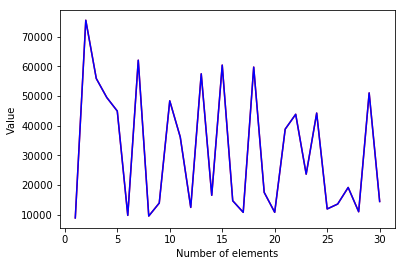

In [52]:
test9 = plot_func(X.iloc[730:760,7],'red','Original Data')
test_10 = plot_func(df_new.iloc[730:760,7],'blue','Anomalous Data') 

# Data Smoothing

In [16]:
r = df_new.rolling(60).mean()

In [17]:
data_smooth = pd.DataFrame(r.iloc[59:,:])

In [18]:
data_smooth.shape

(76071, 9)

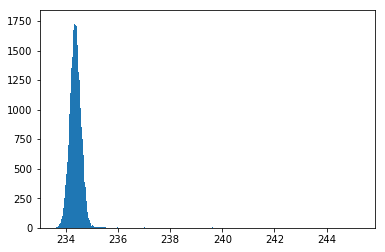

In [19]:
plt.hist(data_smooth.iloc[:,0],bins=1000)
plt.show()

# End of Data Smoothing

In [20]:
#PCA Implementation
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(data_smooth)

X_non_smoothed = StandardScaler().fit_transform(df_new)

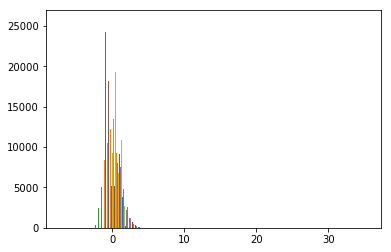

In [21]:
plt.hist(X_non_smoothed,bins=100)
plt.show()

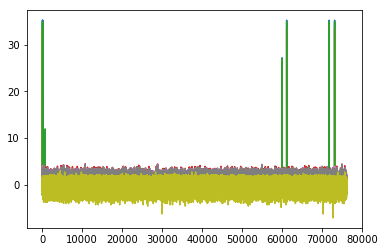

In [22]:
plt.plot(X_non_smoothed)
plt.show()

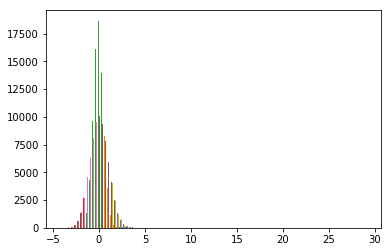

In [23]:
plt.hist(X_std,bins=100)
plt.show()

In [24]:
X_std[1000]

array([ 0.5582168 ,  0.62857709,  0.6422214 , -0.45584056, -0.55327863,
       -0.43292456, -0.4877729 , -0.48358296, -0.15573154])

In [25]:
#Calculate the z-score of all the points
from scipy import stats
zscore = stats.zscore(df_new)

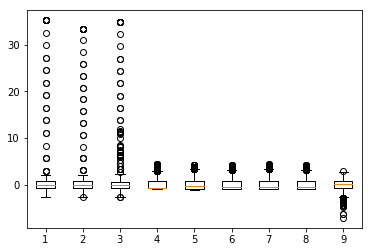

In [26]:
plt.boxplot(zscore)
plt.show()

In [27]:
from sklearn.decomposition import PCA 
sklearn_pca = PCA(n_components=9)
Y_sklearn = sklearn_pca.fit_transform(X_std)
Y_sklearn_ns = sklearn_pca.fit_transform(X_non_smoothed)

sklearn_pca.explained_variance_ratio_.cumsum()

array([ 0.66610582,  0.90773543,  0.98823851,  0.99421021,  0.99770213,
        0.99944135,  0.99990973,  0.99998258,  1.        ])

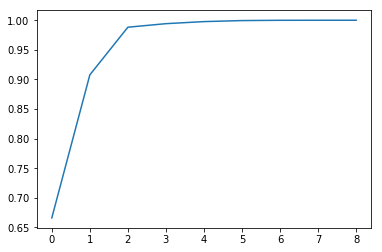

In [28]:
plt.plot(sklearn_pca.explained_variance_ratio_.cumsum())

In [29]:
#Convert the PCA to dataframe
data = pd.DataFrame(Y_sklearn_ns[:,0:3], columns=('PCA1', 'PCA2','PCA3'))
data.head()



,PCA1,PCA2,PCA3
0,-2.348910,-1.803628,0.257402
1,-1.531184,-0.981083,-0.429280
2,-0.099248,1.044407,0.025942
3,-4.017864,-0.382414,-0.927558
4,-3.665352,-0.065545,-0.366003


/home/arun/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


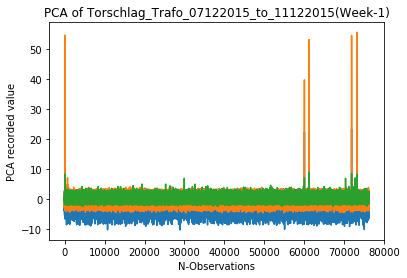

In [30]:
#Plot the PCA values
fig = plt.figure() 
plt.legend(loc='upper right')
plt.plot(data)
plt.title("PCA of Torschlag_Trafo_07122015_to_11122015(Week-1)")

#plt.legend()
plt.ylabel("PCA recorded value")
plt.xlabel("N-Observations")

# Split the data into training and testing 

def split_data(data, val_size=0, test_size=0):
    """
    splits data to training, validation and testing parts
    """
    ntest = int(round(len(data) * (1 - test_size)))
    nval = int(round(len(data.iloc[:ntest]) * (1 - val_size)))
    df_train, df_val, df_test = data.iloc[:nval], data.iloc[nval:ntest], data.iloc[ntest:]
    return df_train, df_val, df_test

train, validate, test = split_data(data)

# Splitting data ends

# Method 1 : Choose the best model

In [31]:
#Fit GMM on the PCA
from sklearn.mixture import GaussianMixture
import pylab as pl

def model_fit_1(X):
    n_components = np.arange(1, 21)
    BIC = np.zeros(n_components.shape)
    AIC = np.zeros(n_components.shape)
    for i, n in enumerate(n_components):
        clf = GaussianMixture(n_components=n, covariance_type='full')
        clf.fit(X)
        AIC[i] = clf.aic(X)
        BIC[i] = clf.bic(X)
    pl.figure()
    pl.plot(n_components, AIC, label='AIC')
    pl.plot(n_components, BIC, label='BIC')
    pl.legend(loc=0)
    pl.xlabel('n_components')
    pl.ylabel('AIC / BIC')
    return clf, AIC, BIC

def gmm_ad(wgt_log_probability):
    values = []
    index = []
    threshold = 3 * wgt_log_probability.std() #Check if we can consider since its not a normal distribution
    a = np.absolute(wgt_log_probability.mean()) + threshold
    count = 0
    for i in range(0,len(wgt_log_probability)):
        #print i
        if np.absolute(wgt_log_probability[i]) > a:
            count = count + 1
            values.append(wgt_log_probability[i])
            index.append(i)
    return count, values, index
    #print values

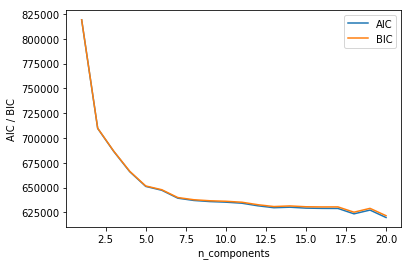

In [32]:
clf, clf_aic, clf_bic  = model_fit_1(data)

In [33]:
clf.weights_ #the weights of no_of_components, see first parameter to GaussianMixture

array([ 0.04994821,  0.05272007,  0.01986362,  0.11979502,  0.01926054,
        0.00101058,  0.05065287,  0.03037979,  0.15167621,  0.02734775,
        0.06298776,  0.0706613 ,  0.04017336,  0.02559466,  0.02565223,
        0.05275257,  0.0616578 ,  0.03539884,  0.0530555 ,  0.04941132])

In [34]:
clf.means_.shape #(n_components, n_features)

(20, 3)

The precision matrices for each component in the mixture. **A precision matrix is the inverse of a covariance matrix.** A covariance matrix is symmetric positive definite so the mixture of Gaussian can be equivalently parameterized by the precision matrices. Storing the precision matrices instead of the covariance matrices makes it more efficient to compute the log-likelihood of new samples at test time. The shape depends on covariance_type:

In [35]:
clf.covariances_.shape #(n_components, n_features, n_features) if 'full'

(20, 3, 3)

In [36]:
clf.precisions_.shape #

(20, 3, 3)

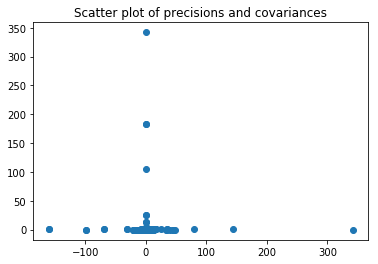

In [37]:
plt.scatter(clf.precisions_, clf.covariances_)
plt.title('Scatter plot of precisions and covariances')

In [38]:
classes = clf.predict(data)
classes

array([ 6,  6, 15, ...,  8, 17, 15])

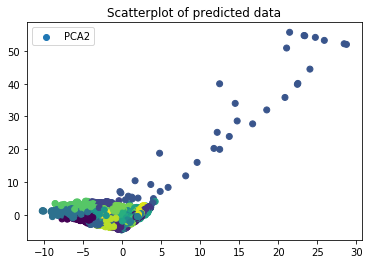

In [39]:
classes = clf.predict(data)
plt.scatter(data.iloc[:,0], data.iloc[:,1], c=classes)
plt.legend()
plt.title('Scatterplot of predicted data')
plt.show()

In [40]:
score_samp = clf.score_samples(data) #Compute the weighted log probabilities for each sample.

In [41]:
np.savetxt("Original_data.txt",score_samp)

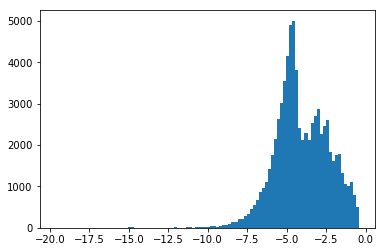

In [42]:
plt.hist(score_samp,bins =100)
plt.show()

# Calculate the confidence intervals

In [43]:
#http://stackoverflow.com/questions/4493543/calculating-confidence-intervals-for-a-non-normal-distribution
def CI_dist(X):
    N = len(X)
    mu = np.mean(abs(X))         # sample mean (normally distributed)
    print("Mean = %s"%mu)
    #sig = np.std(X)/math.sqrt(N); # sample standard deviation of the mean
    sig = np.std(X) # sample standard deviation of the mean
    print("Std = %s"%sig)
    alphao2 = .05/2;      # alpha over 2   
    CI = stats.norm.ppf(0.95, loc=mu, scale= 2.5*sig)
    return CI

In [44]:
CI = CI_dist(score_samp)
CI

Mean = 4.06892752477
Std = 1.71805772476


11.133811224467124

# Calculate the number of data points lower than -10

In [45]:
def count_no_of_points(dist,confidence_interval,filename):
    count = 0
    anomalous_values = []
    idx = []
    for i in dist:
        if i < -confidence_interval:
            count += 1
            k, = np.where(dist == i)
            idx.append(k)
            anomalous_values.append(i)
    np.savetxt(filename,anomalous_values)
    return count,idx

In [46]:
less_probable_value_count, idx_ap = count_no_of_points(score_samp,CI,"test_anomaly_range_11.txt")
less_probable_value_count, idx_ap

(137,
 [array([79]),
  array([80]),
  array([81]),
  array([82]),
  array([83]),
  array([84]),
  array([85]),
  array([86]),
  array([87]),
  array([88]),
  array([89]),
  array([99]),
  array([119]),
  array([487]),
  array([739]),
  array([740]),
  array([741]),
  array([742]),
  array([743]),
  array([744]),
  array([745]),
  array([747]),
  array([749]),
  array([750]),
  array([751]),
  array([ 4058, 58393]),
  array([ 4368, 35354, 64912]),
  array([5354]),
  array([6055]),
  array([ 6222, 18865]),
  array([6461]),
  array([ 7916, 17139, 25255]),
  array([ 8439, 71099]),
  array([11005]),
  array([11180, 33391]),
  array([11839]),
  array([13370]),
  array([13897, 60411]),
  array([13992, 31986]),
  array([14032]),
  array([14499]),
  array([14746, 24122]),
  array([14935]),
  array([16502]),
  array([ 7916, 17139, 25255]),
  array([17159]),
  array([ 6222, 18865]),
  array([19380]),
  array([19485, 43308]),
  array([20627]),
  array([23642]),
  array([23752]),
  array([14746, 24